In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/simulated-sales-data-with-timeseries-features/sales.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the data
data = pd.read_csv('/kaggle/input/simulated-sales-data-with-timeseries-features/sales.csv')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
print(data.head())

   Unnamed: 0        Date      Sales
0           0  2021-10-01  29.109547
1           1  2021-10-02  30.720435
2           2  2021-10-03  30.305173
3           3  2021-10-04  27.390893
4           4  2021-10-05  22.841123


In [4]:
# Data Preprocessing
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(by='Date')
data.set_index('Date', inplace=True)

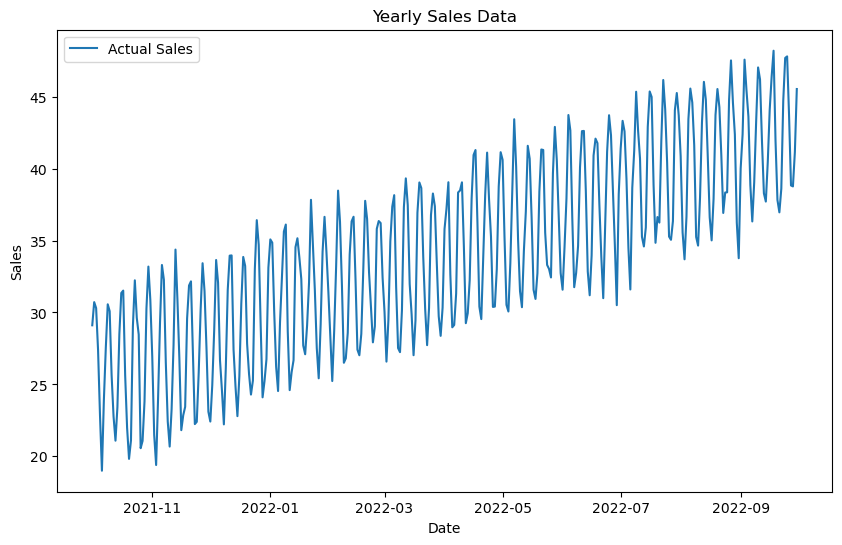

In [5]:
# Data Visualization
plt.figure(figsize=(10, 6))
plt.plot(data['Sales'], label='Actual Sales')
plt.title('Yearly Sales Data')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [6]:
# Train-test split
train_size = int(0.8 * len(data))
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]


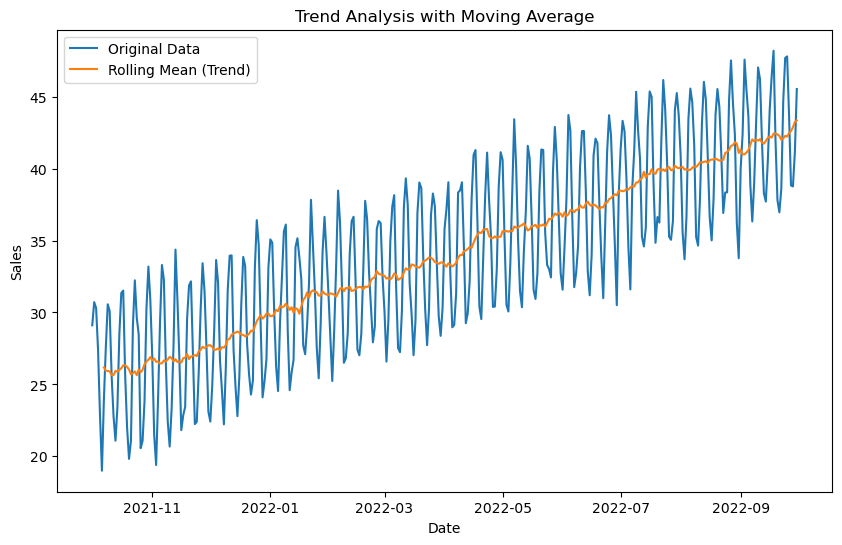

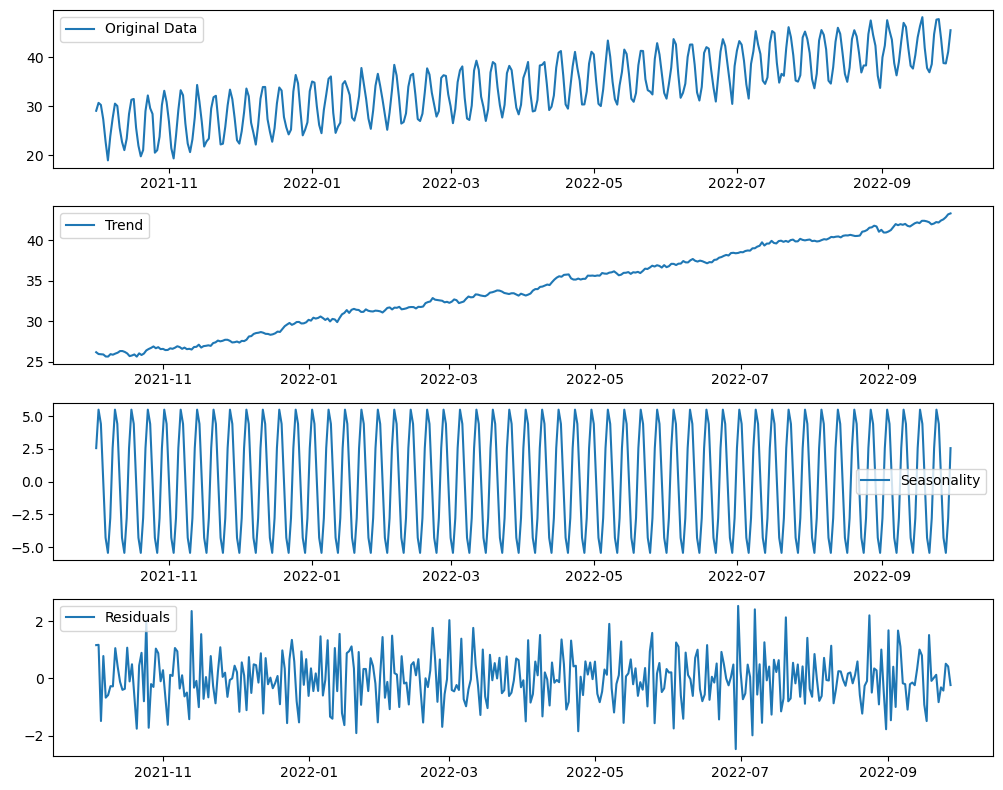

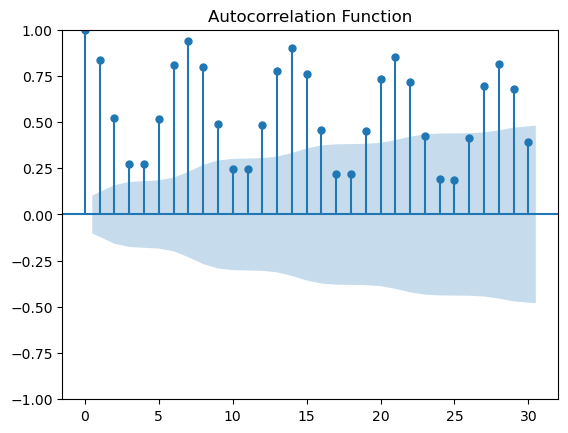

In [7]:


# Trend Analysis using Moving Average
rolling_mean = data['Sales'].rolling(window=7).mean()  # Example window size of 7
plt.figure(figsize=(10, 6))
plt.plot(data['Sales'], label='Original Data')
plt.plot(rolling_mean, label='Rolling Mean (Trend)')
plt.title('Trend Analysis with Moving Average')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Seasonal Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data['Sales'], model='additive', period=7)  # Example period of 7
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(data['Sales'], label='Original Data')
plt.legend()
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend()
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend()
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend()
plt.tight_layout()
plt.show()

# Autocorrelation Analysis
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data['Sales'], lags=30)  # Example lag values up to 30
plt.title('Autocorrelation Function')
plt.show()


In [8]:
orders = [(1, 1, 1), (1, 1, 2), (2, 1, 1)]
seasonal_orders = [(1, 1, 1, 7), (1, 1, 2, 7), (2, 1, 1, 7)]
best_mae = float('inf')
best_model = None

for order in orders:
    for seasonal_order in seasonal_orders:
        model = SARIMAX(train_data['Sales'], order=order, seasonal_order=seasonal_order)
        fit_model = model.fit(disp=False)
        forecast = fit_model.get_forecast(steps=len(test_data))
        forecasted_sales = forecast.predicted_mean
        mae = mean_absolute_error(test_data['Sales'], forecasted_sales)
        
        if mae < best_mae:
            best_mae = mae
            best_model = fit_model
            best_order = order
            best_seasonal_order = seasonal_order

print(f"Best MAE: {best_mae}")
print(f"Best Order: {best_order}")
print(f"Best Seasonal Order: {best_seasonal_order}")


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

Best MAE: 0.7299885002845456
Best Order: (1, 1, 2)
Best Seasonal Order: (2, 1, 1, 7)


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [9]:
forecast = best_model.get_forecast(steps=len(test_data))
forecasted_sales = forecast.predicted_mean


In [10]:
mae = mean_absolute_error(test_data['Sales'], forecasted_sales)
rmse = np.sqrt(mean_squared_error(test_data['Sales'], forecasted_sales))
print(f"MAE using Best Model: {mae}")
print(f"RMSE using Best Model: {rmse}")


MAE using Best Model: 0.7299885002845456
RMSE using Best Model: 0.939795693860709


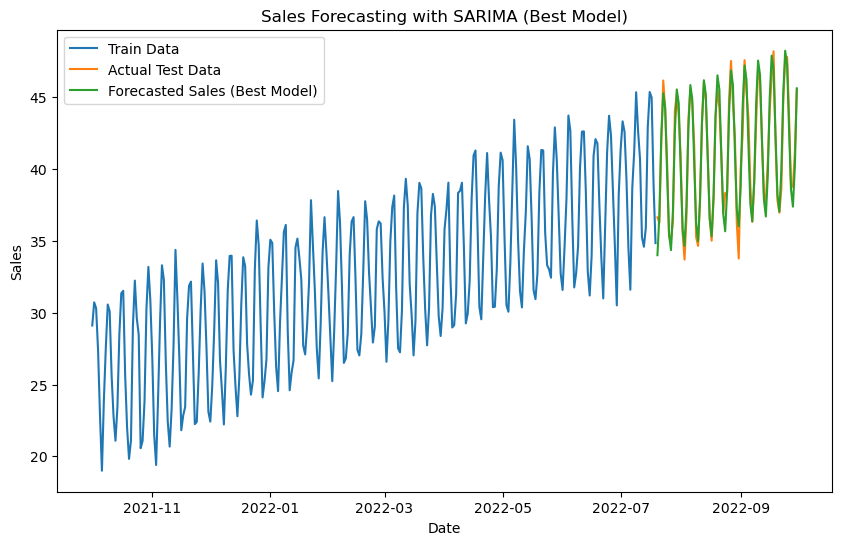

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['Sales'], label='Train Data')
plt.plot(test_data.index, test_data['Sales'], label='Actual Test Data')
plt.plot(test_data.index, forecasted_sales, label='Forecasted Sales (Best Model)')
plt.title('Sales Forecasting with SARIMA (Best Model)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


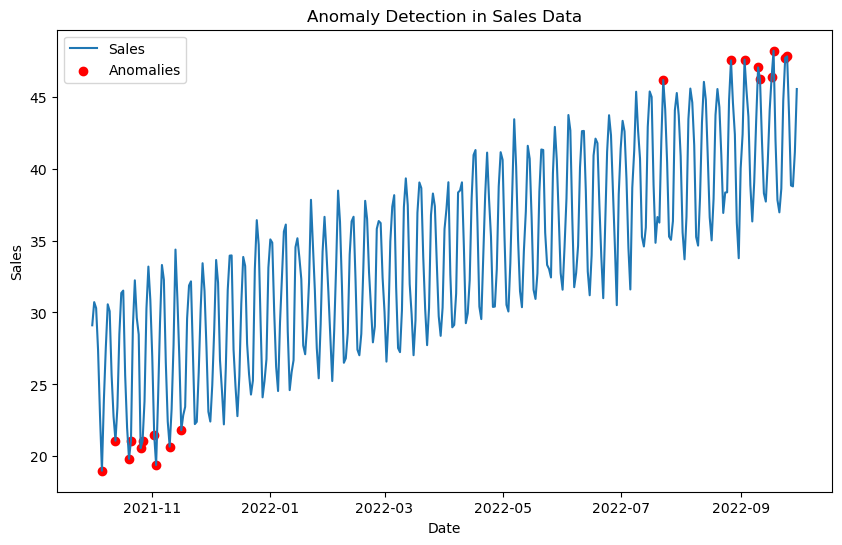

In [12]:

from sklearn.ensemble import IsolationForest


# Create a feature using sales values
data['Sales'] = data['Sales'].astype(float)
X = data[['Sales']].values

# Train the Isolation Forest model
model = IsolationForest(contamination=0.05)  # Adjust contamination based on your data
model.fit(X)

# Predict anomalies
anomaly_labels = model.predict(X)
data['Anomaly'] = anomaly_labels

# Plot the data with anomalies highlighted
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Sales'], label='Sales')
plt.scatter(data[data['Anomaly'] == -1].index, data[data['Anomaly'] == -1]['Sales'], color='red', label='Anomalies')
plt.title('Anomaly Detection in Sales Data')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()
